In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import numpy as np

%matplotlib inline

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_set = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, x_test))


def add_noise(x, y):
    x = x + NOISE_FACTOR * tf.random.normal(shape=[28, 28, 1])
    x = tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.)
    return x, y
    

NOISE_FACTOR = 0.2
BATCH_SIZE = 32

train_set = train_set.batch(BATCH_SIZE).map(add_noise, num_parallel_calls=AUTOTUNE).prefetch(1)
test_set = test_set.batch(BATCH_SIZE).map(add_noise, num_parallel_calls=AUTOTUNE).prefetch(1)

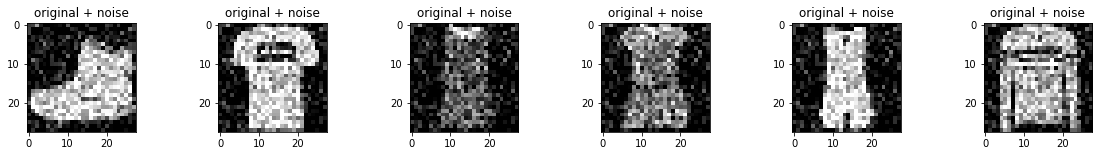

In [3]:
noisy_images, images = next(tfds.as_numpy(train_set.take(1)))
n = 6

plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(np.squeeze(noisy_images[i], axis=-1))
    plt.gray()

In [4]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(train_set,
                epochs=10,
                shuffle=True,
                validation_data=test_set)

Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0192 - val_loss: 0.0103
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 4/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0089 - val_loss: 0.0086 6s - loss - ETA: 5s 
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 7/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 9/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 10/10
1875/1875 [====================

In [7]:
noisy_test, original_test = next(tfds.as_numpy(test_set.take(1)))

encoded_imgs = autoencoder.encoder(noisy_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

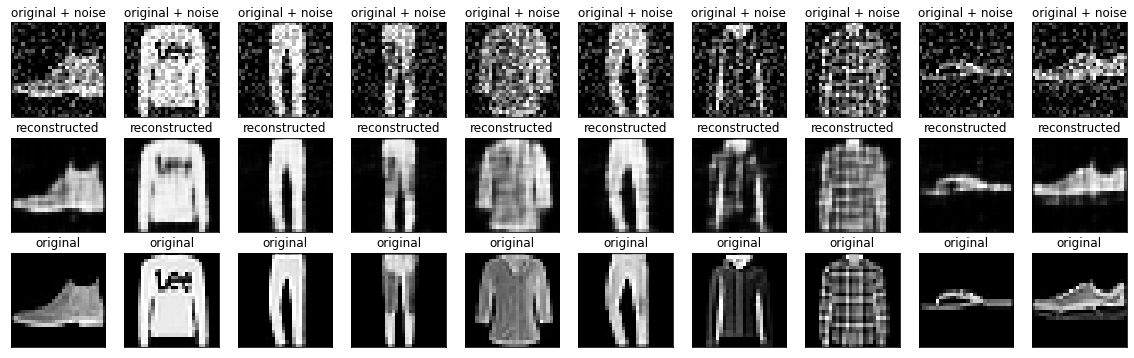

In [8]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(noisy_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display original
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(original_test[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)